Todo 

Ajouter des étapes quand on calcul matrice ABC et changé de non pour les matrices
Est-ce que afficher les 18 courbes a un sens
d'ou vient R1CS

Faire un notebook propre pédagogue.

Avoir les memes resulats que dans le papier risencrypto sur un autre notebook.

d'ou vient cette division + convolution ??? Voir avec JM ? 



# SNARK : Modélisation Simple (R1CS vers QAP)
Dans ce notebook, nous explorons le processus de conversion d'une équation polynomiale en un système de contraintes R1CS (Rank 1 Constraint Systems) puis en un QAP (Quadratic Arithmetic Programs). 

L'exemple donné est celui où Bob souhaite prouver qu'il connaît un secret \( x \) tel que \( x^3+x+5 = 35 \). Nous allons décomposer cette équation, la modéliser sous forme de circuit arithmétique, puis la convertir en un système R1CS.


In [1]:
import zktool as zk
import numpy as np


## Entrée de l'équation
Veuillez entrer une équation polynomiale de type \( x^3 + x + 5 \). Nous allons ensuite la décomposer et la modéliser sous forme de circuit arithmétique.


In [2]:
eq_input=input("Enter the equation: de type x^3 + x + 5") #METTRE DES COEFFICIENTS >=0, aucune negatif pour l'instant


## Décomposition de l'équation et Modélisation des Circuits Arithmétiques
Une fois que nous avons l'équation, nous pouvons la décomposer en termes individuels et la représenter sous forme de circuit arithmétique. Le résultat ci-dessous montre cette représentation.


In [3]:
equations = zk.decompose_polynomial(eq_input)
unique_words = zk.get_unique_words(equations)

print("Modelisation des circuits arithmetiques :")
for eq in equations:
    print(eq)


print("\nEnsemble des varibles =",unique_words)


Modelisation des circuits arithmetiques :
power_1 = x * x
power_2 = power_1 * x
equation_3 = power_2 + x
equation_4 = equation_3 + 3

Ensemble des varibles = {'power_2', 'equation_4', '1', 'x', 'power_1', 'equation_3'}



## Conversion du Circuit en R1CS
Le système R1CS (Rank 1 Constraint Systems) est une façon de représenter un ensemble de contraintes sous forme de matrices. Pour chaque équation du circuit, nous allons créer trois vecteurs associés (un pour chaque matrice A, B, C) qui représentent cette équation dans le système R1CS.


In [15]:
#création des 3 matrice vides A B C
L= []
R= []
O= []

for eq in equations:
    print(eq)
print(" ")

ref_array=list(unique_words)
print(ref_array)
print(' ')

for eq in equations:
    eq_split=eq.split()
    #print(eq_split)

    if eq_split[3]=='*':
        vecta=zk.get_position_vector(list(unique_words), eq_split[2])
        L.append(vecta)
        vectb=zk.get_position_vector(list(unique_words), eq_split[4])
        R.append(vectb)
        vectc=zk.get_position_vector(list(unique_words), eq_split[0])
        O.append(vectc)

    if eq_split[3]=='+':
        vecta=zk.get_position_vector(list(unique_words), [eq_split[2],eq_split[4]])
        L.append(vecta)
        vectb=zk.get_position_vector(list(unique_words), "1")
        R.append(vectb)
        vectc=zk.get_position_vector(list(unique_words), eq_split[0])
        O.append(vectc)
        
print("L=")
for ligne in L:
    print(ligne)
print(" ")

print("R=")
for ligne in R:
    print(ligne)
print(" ")

print("O=")
for ligne in O:
    print(ligne)
print(" ")

power_1 = x * x
power_2 = power_1 * x
equation_3 = power_2 + x
equation_4 = equation_3 + 3
 
['power_2', 'equation_4', '1', 'x', 'power_1', 'equation_3']
 
L=
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 0]
[1, 0, 0, 1, 0, 0]
[0, 0, 3, 0, 0, 1]
 
R=
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
 
O=
[0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 0]
 


## Conversion R1CS en QAP

PolyL:
 [[ -0.5          3.5         -7.           4.        ]
 [  0.           0.           0.           0.        ]
 [  0.5         -3.           5.5         -3.        ]
 [ -0.66666667   5.         -11.33333333   8.        ]
 [  0.5         -4.           9.5         -6.        ]
 [  0.16666667  -1.           1.83333333  -1.        ]]


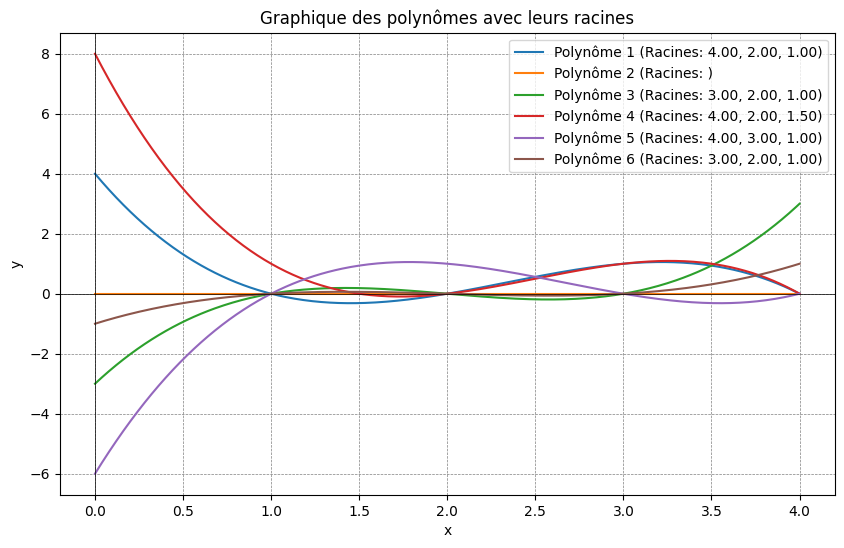


PolyR:
 [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.33333333  2.5        -5.16666667  3.        ]
 [ 0.33333333 -2.5         5.16666667 -2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


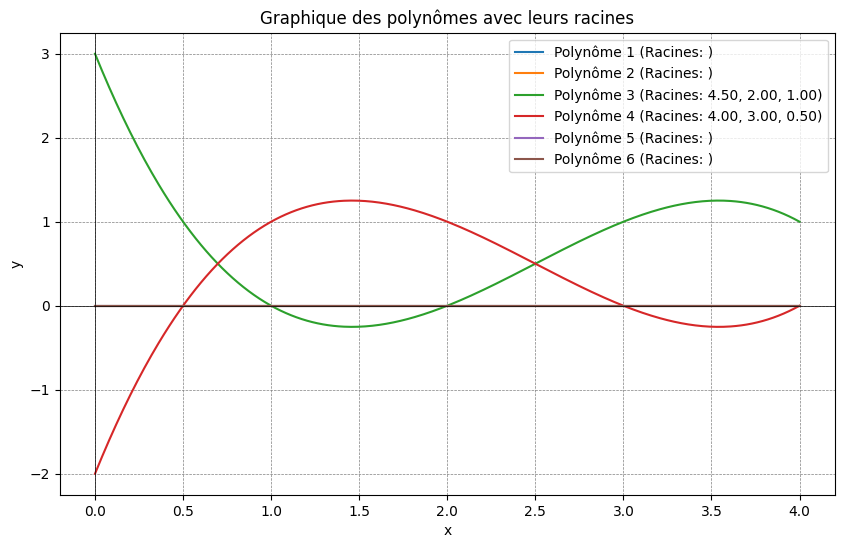


PolyO:
 [[ 0.5        -4.          9.5        -6.        ]
 [ 0.16666667 -1.          1.83333333 -1.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.16666667  1.5        -4.33333333  4.        ]
 [-0.5         3.5        -7.          4.        ]]


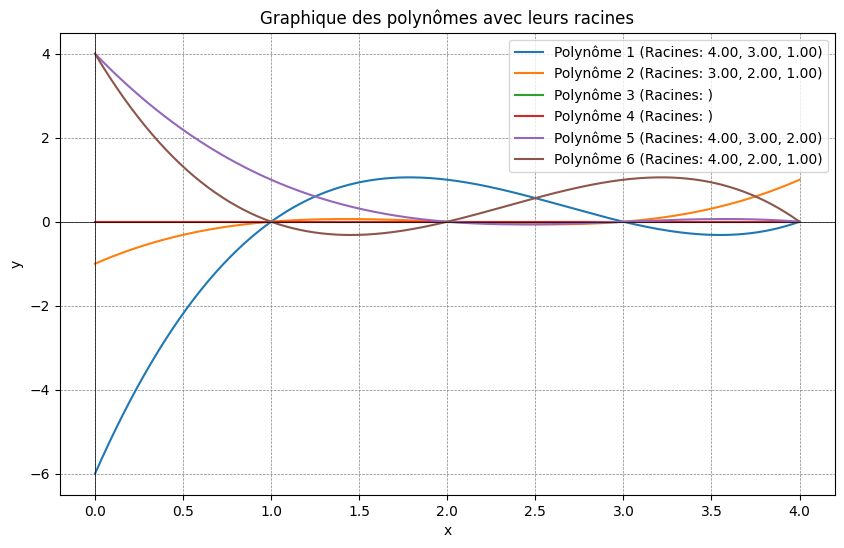

In [18]:
#Ici on cherche les coefficients des polynomes de chaque matrice

L=np.array(L)
R=np.array(R)
O=np.array(O)

# Convert matrices to their transpose for calculations
At, Bt, Ct = L.transpose(), R.transpose(), O.transpose()

# Calculate polynomial coefficient matrices
PolyL = zk.interpolate_and_get_coeff_matrix(At)
PolyR = zk.interpolate_and_get_coeff_matrix(Bt)
PolyO = zk.interpolate_and_get_coeff_matrix(Ct)

print("PolyL:\n", PolyL)
zk.plot_polynomials(PolyL,[0,4])

print("\nPolyR:\n", PolyR)
zk.plot_polynomials(PolyR,[0,4])

print("\nPolyO:\n", PolyO)
zk.plot_polynomials(PolyO,[0,4])


## Calcul de la preuve

In [6]:
values = {"x": 3}

S = zk.compute_solution_vector(unique_words, equations, values)
print("\nSolution Vector:", S)

#S=[3, 1, 9, 34, 27, 30]
#S=[27, 3, 9, 30, 35, 10] #A décommenter pour tester la vérification de la solution fausse
#S=[27, 3, 9, 30, 34, 1] #A décommenter pour tester la vérification de la solution fausse
#S=[27, 3, 9, 31, 35, 1] #A décommenter pour tester la vérification de la solution fausse
#S=[27, 3, 10, 30, 35, 1] #A décommenter pour tester la vérification de la solution fausse
#S=[0, 0, 0, 0, 0, 0] #A décommenter pour tester la vérification de la solution fausse


power_1 = 9
power_2 = 27
equation_3 = 30
equation_4 = 33

Solution Vector: [27, 33, 1, 3, 9, 30]


-Imaginions si le prouver ne connait pas la solution, il va donner un x qui ne correspond pas à out. Ici x=3 donc la fonction zk.compute_solution_vector va forcement calculer la bonne sortie 35 => Solution Vector: [3, 1, 9, 35, 27, 30].

-Si on veut tester un prouver qui ne connait pas le solution on peux changer manuellement S = [3, 1, 9, **34**, 27, 30]. Maintenant il suffit d'aller voir la fin du programme pour voir si le verifier approuve ou non la preuve.

T = [  -96.           628.         -1119.66666667   847.5
  -310.66666667    54.5           -3.66666667]
racine de T = [4.24225319 1.         0.5        0.33333333 0.25       0.21608014]


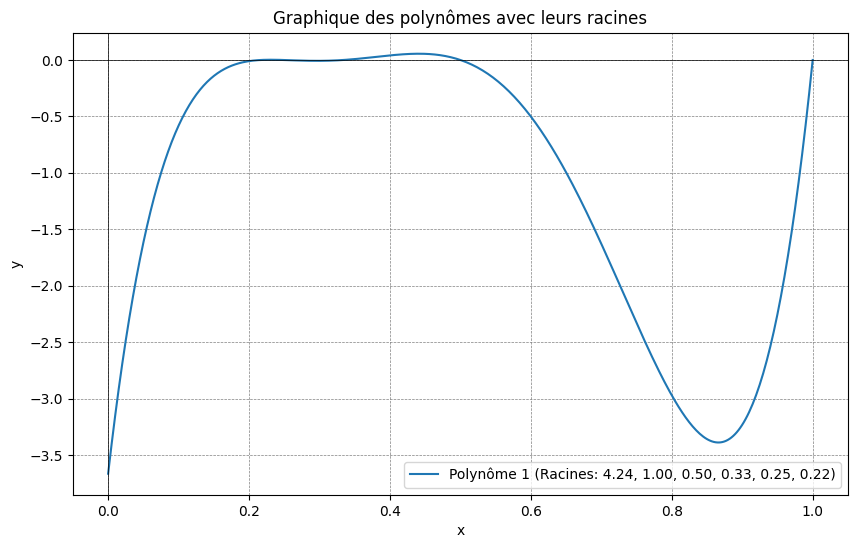

A.S = [ 45.  -77.   40.5  -5.5]
racine de AS = [0.75147245+0.14975583j 0.75147245-0.14975583j 0.20816622+0.j        ]


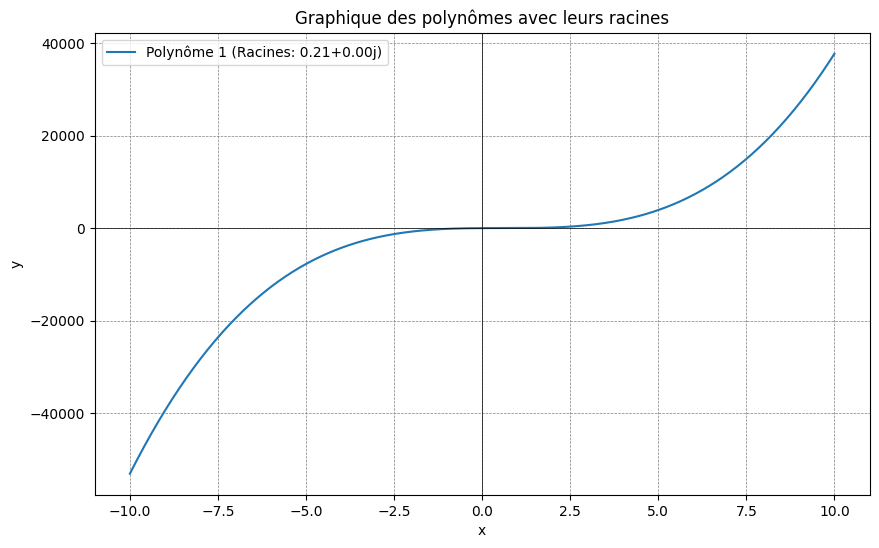

B.S = [-3.         10.33333333 -5.          0.66666667]
racine de BS = [2.89531011+0.j         0.27456717+0.03695061j 0.27456717-0.03695061j]


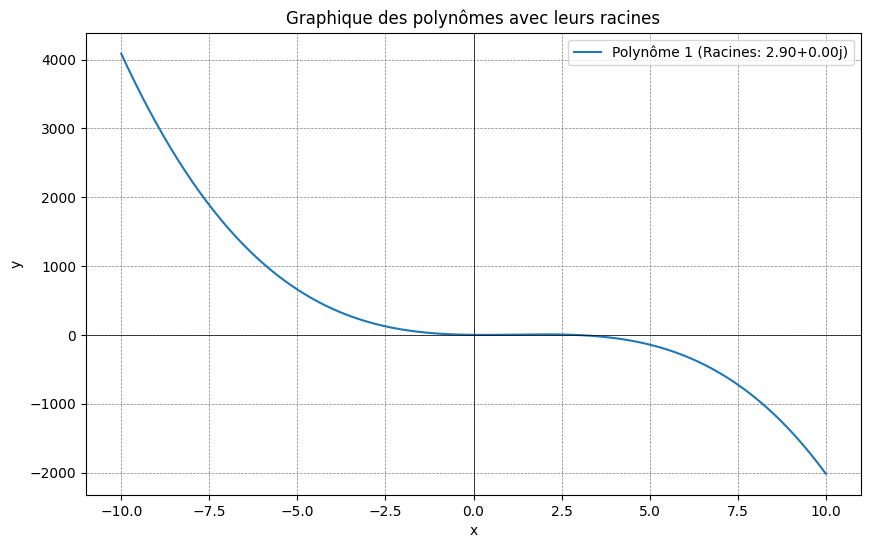

C.S = [-39.   68.  -22.5   2.5]
racine de CS = [1.35191902+0.j         0.19583536+0.09520762j 0.19583536-0.09520762j]


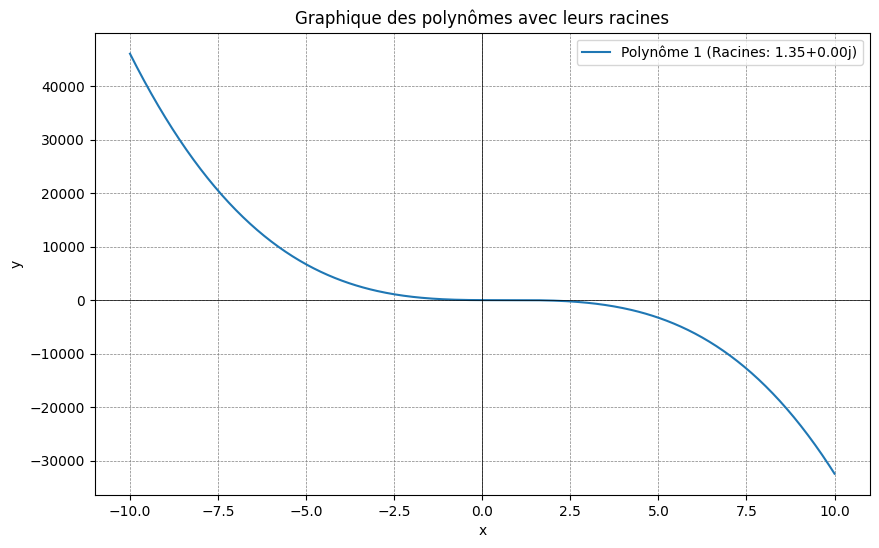

In [19]:
#Ici on chercher trouver le polynome T qui repond à tous les polynomes de la matrice A;B;C
result_LS = zk.polynomial_dot_product(PolyL, S)
result_RS = zk.polynomial_dot_product(PolyR, S)
result_OS = zk.polynomial_dot_product(PolyO, S)

# print("A.S =", result_AS)
# print("B.S =", result_BS)
# print("C.S =", result_CS)

# Calcul de la convolution
convolution_product = np.convolve(result_LS, result_RS)

# Calcul de T
T = convolution_product - np.concatenate((result_OS, np.zeros(len(convolution_product) - len(result_OS))))

print("T =", T)

print("racine de T =", np.roots(T))
zk.plot_polynomials([T],[0,1])

print("A.S =", result_LS)
print("racine de AS =", np.roots(result_LS))
zk.plot_polynomials([result_LS])

print("B.S =", result_RS)
print("racine de BS =", np.roots(result_RS))
zk.plot_polynomials([result_RS])

print("C.S =", result_OS)
print("racine de CS =", np.roots(result_OS))
zk.plot_polynomials([result_OS])



In [8]:
# Z est le diviseur de T pour verifier s'il y a un reste ou non
Z = zk.polynomial_coefficients(len(equations))
print("Z =", Z)

Z = [ 24 -50  35 -10   1]


In [9]:
quotient,remainder=zk.polynomial_division(T, Z)

# Imprimer le quotient
print(f"h = T / Z = {quotient}")
print(f"R = T % Z = {remainder}")

# Vérifiez si le reste est nul
if not zk.is_remainder_close_to_zero(remainder, 1e-5):
    print("La preuve est refutée !")
else:
    print("La preuve est bonne")

h = T / Z = [-4.         17.83333333 -3.66666667]
R = T % Z = [-4.88498131e-15]
La preuve est bonne
